### <center> DATA 612: Decision Analytics Capstone
### <center> Clutch Time Analytics:
### <center> Simulating Late-Game Strategies in Basketball
<center> James Oblea

<center> University of Calgary

<center> Faculty of Business

<center> DATA 612: Decision Analytics

<center> Instructor: Osman Alp

<center> April 9, 2024

In [1]:
import numpy as np
import simpy as sp
import pandas as pd
import matplotlib.pyplot as plt
from fitter import Fitter
from scipy.stats import expon
from scipy.stats import gamma

Data Prep and Wrangling

In [2]:
pbp = pd.read_csv("NBA_PBP_2018-19.csv") # data from https://www.kaggle.com/datasets/schmadam97/nba-playbyplay-data-20182019?select=NBA_PBP_2018-19.csv

In [3]:
## It could be more efficient and accurate to filter for the last two minutes of a close game (decided by two posessessions or less)
## as the pace, shot selection, and overall strategies could be different

close_games = pbp[(abs(pbp.AwayScore - pbp.HomeScore) < 7) & (pbp.AwayPlay == "End of 4th quarter")] # games decided by two or less posessions

last_two_minutes = pbp[(pbp.SecLeft < 6*20) & (pbp.Quarter == 4) & (pbp.URL.isin(close_games.URL))]

# Getting rid of unnecessary (to the below study) rows in the pbp such as timeouts and substitutions
last_two_minutes.drop(last_two_minutes[last_two_minutes.TimeoutTeam.notna() | last_two_minutes.EnterGame.notna() | last_two_minutes.LeaveGame.notna()].index,inplace = True)

C:\Users\j_chr\AppData\Local\Temp\ipykernel_11136\3513224298.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_two_minutes.drop(last_two_minutes[last_two_minutes.TimeoutTeam.notna() | last_two_minutes.EnterGame.notna() | last_two_minutes.LeaveGame.notna()].index,inplace = True)


In [4]:
possession_to = pd.Series(len(last_two_minutes))

# To measure the time between the start of possession and an event, we have to define when a team gains possession
for row in last_two_minutes.index.values:
    
    # If the Team gets a rebound (offensive or defensive) they gain posession
    if last_two_minutes.HomePlay.notna().loc[row] & last_two_minutes.Rebounder.notna().loc[row]:
        possession_to[row] = last_two_minutes.HomeTeam[row]

    elif last_two_minutes.AwayPlay.notna().loc[row] & last_two_minutes.Rebounder.notna().loc[row]:
        possession_to[row] = last_two_minutes.AwayTeam[row]

    # If the opposite Team commits a turnover, the Team gains posession
    if last_two_minutes.HomePlay.notna().loc[row] & last_two_minutes.TurnoverPlayer.notna().loc[row]:
        possession_to[row] = last_two_minutes.AwayTeam[row]

    elif last_two_minutes.AwayPlay.notna().loc[row] & last_two_minutes.TurnoverPlayer.notna().loc[row]:
        possession_to[row] = last_two_minutes.HomeTeam[row]

    # If the opposite Team makes a field goal (any shot except free throws), the Team gains possession
    if last_two_minutes.HomePlay.notna().loc[row] & (last_two_minutes.ShotOutcome.loc[row] == "make"):
        possession_to[row] = last_two_minutes.AwayTeam[row]

    elif last_two_minutes.AwayPlay.notna().loc[row] & (last_two_minutes.ShotOutcome.loc[row] == "make"):
        possession_to[row] = last_two_minutes.HomeTeam[row]

        # If the opposite Team makes a free throw, the Team gains possession
    if last_two_minutes.HomePlay.notna().loc[row] & (last_two_minutes.FreeThrowOutcome.loc[row] == "make") & (last_two_minutes.FreeThrowNum.loc[row] in ["2 of 2" , "3 of 3"]):
        possession_to[row] = last_two_minutes.AwayTeam[row]

    elif last_two_minutes.AwayPlay.notna().loc[row] & (last_two_minutes.FreeThrowOutcome.loc[row] == "make") & (last_two_minutes.FreeThrowNum.loc[row] in ["2 of 2" , "3 of 3"]):
        possession_to[row] = last_two_minutes.HomeTeam[row]

    # If the Team wins the jump-ball they gain posession
    if last_two_minutes.HomePlay.notna().loc[row] & last_two_minutes.JumpballPoss.notna().loc[row]:
        possession_to[row] = last_two_minutes.HomeTeam[row]

    elif last_two_minutes.AwayPlay.notna().loc[row] & last_two_minutes.JumpballPoss.notna().loc[row]:
        possession_to[row] = last_two_minutes.AwayTeam[row]

last_two_minutes['possession_to'] = possession_to

C:\Users\j_chr\AppData\Local\Temp\ipykernel_11136\3454766044.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_two_minutes['possession_to'] = possession_to


In [5]:
shots = pd.Series()
fouls = pd.Series()
turnovers = pd.Series()

possession_start_time = 0
shot_time = 0
foul_time = 0
turnover_time = 0

# The for-loop below measures the time between events
for row in last_two_minutes.index.values:


    if last_two_minutes.Shooter.notna()[row]:
        shot_time = last_two_minutes.SecLeft[row]
        inter_arrival_shot = possession_start_time - shot_time
        shots[row] = inter_arrival_shot
        possession_start_time = 0

    if last_two_minutes.FoulType.notna()[row]:
        foul_time = last_two_minutes.SecLeft[row]
        inter_arrival_foul = possession_start_time - foul_time
        fouls[row] = inter_arrival_foul
        possession_start_time = 0

    if last_two_minutes.TurnoverPlayer.notna()[row]:
        turnover_time = last_two_minutes.SecLeft[row]
        inter_arrival_turnover = possession_start_time - turnover_time
        turnovers[row] = inter_arrival_turnover
        possession_start_time = 0

    if last_two_minutes.possession_to.notna()[row]:
        possession_start_time = last_two_minutes.SecLeft[row]

# pbp data has data for consecutive games - difference in game time will be negative between these instances
shots = shots[shots >= 0]
fouls = fouls[fouls >= 0]
turnovers = turnovers[turnovers >= 0]

Fitting distributions

Traditionally, exponential and gamma distributions are used to measure the difference in time between events

Text(0.5, 1.0, 'Time elapsed until shot attempt')

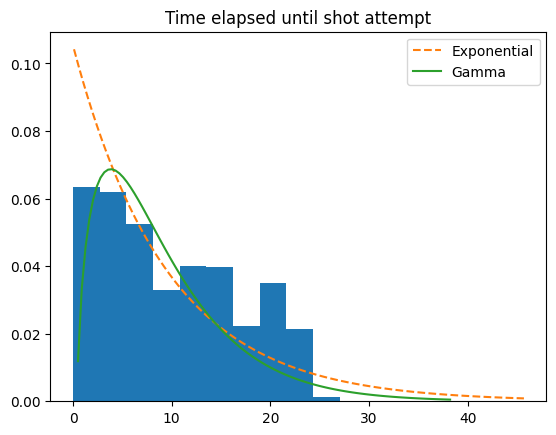

In [6]:
plt.hist(shots, density = True)

x = np.linspace(expon.ppf(0.01, loc = 0, scale = 9.92),
                expon.ppf(0.99, loc = 0, scale = 9.92), 100)
pdf = expon.pdf(x, loc = 0, scale = 9.5)

x_2 = np.linspace(gamma.ppf(0.01, a = 1.64, loc = 0, scale = 6.42),
                gamma.ppf(0.99, a = 1.64, loc = 0, scale = 6.42), 100)
pdf_2 = gamma.pdf(x, a = 1.64, loc = 0, scale = 6.42)
plt.plot(x,pdf, '--', label = "Exponential")
plt.plot(x_2,pdf_2, label = "Gamma")
plt.legend()
plt.title('Time elapsed until shot attempt')

Text(0.5, 1.0, 'Time elapsed until foul')

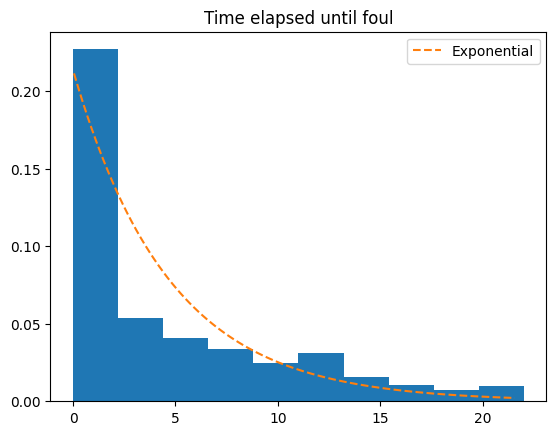

In [7]:
plt.hist(fouls, density = True)
x = np.linspace(expon.ppf(0.01, loc = 0, scale = 4.68),
                expon.ppf(0.99, loc = 0, scale = 4.68), 100)
pdf = expon.pdf(x, loc = 0, scale = 4.68)
plt.plot(x,pdf, '--', label = "Exponential")
plt.legend()
plt.title('Time elapsed until foul')

Text(0.5, 1.0, 'Time elapsed until turnover')

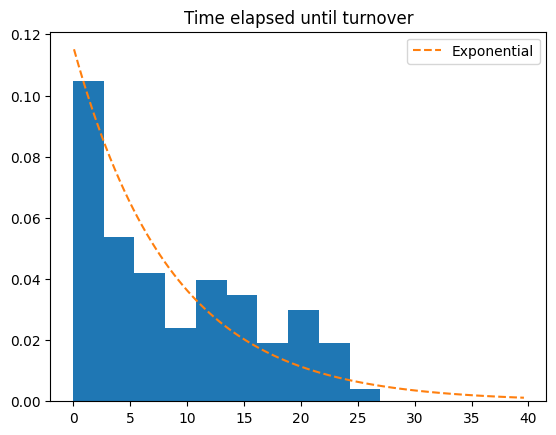

In [8]:
plt.hist(turnovers, density = True)
x = np.linspace(expon.ppf(0.01, loc = 0, scale = 8.6),
                expon.ppf(0.99, loc = 0, scale = 8.6), 100)
pdf = expon.pdf(x, loc = 0, scale = 8.6)
plt.plot(x,pdf, '--', label = "Exponential")
plt.legend()
plt.title('Time elapsed until turnover')

In [9]:
# np.random.seed(612)
# indices = np.random.randint(0,len(shots),size = 30)

# Dist_shots = Fitter(shots.iloc[indices], distributions = ['expon','weibull_min','gamma'])
Dist_shots = Fitter(shots, distributions = ['expon','weibull_min','gamma'])
Dist_shots.fit()
Dist_shots.summary(plot = False)
# Dist_shots.summary()

2024-04-08 15:31:40.521 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.444283)
2024-04-08 15:31:40.942 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.445514)
2024-04-08 15:31:41.062 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.446416)


sumsquare_error         aic         bic  kl_div  ks_statistic  \
expon               0.444283  735.071945  747.206243     inf      0.116364   
weibull_min         0.445514  720.370312  738.571759     inf      0.078825   
gamma               0.446416  726.249821  744.451269     inf      0.086946   

                ks_pvalue  
expon        4.584190e-38  
weibull_min  1.123229e-17  
gamma        2.035836e-21

In [10]:
# np.random.seed(612)
# indices = np.random.randint(0,len(fouls), size = 30)

# Dist_fouls = Fitter(fouls.iloc[indices], distributions = ['expon', 'weibull_min', 'gamma'])
Dist_fouls = Fitter(fouls, distributions = ['expon', 'weibull_min', 'gamma'])
Dist_fouls.fit()
Dist_fouls.summary(plot = False)
# Dist_fouls.summary()

2024-04-08 15:31:41.158 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=1.990238)
2024-04-08 15:31:41.919 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=1.400775)
2024-04-08 15:31:42.048 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=1.182878)


sumsquare_error         aic         bic  kl_div  ks_statistic  \
weibull_min         1.182878  919.964957  935.445165     inf      0.288267   
gamma               1.400775  948.874398  964.354605     inf      0.288267   
expon               1.990238  782.707433  793.027571     inf      0.288267   

                ks_pvalue  
weibull_min  3.491073e-95  
gamma        3.491019e-95  
expon        3.491019e-95

In [11]:
# np.random.seed(612)
# indices = np.random.randint(0,len(turnovers), size = 40)

# Dist_turnovers = Fitter(turnovers.iloc[indices,], distributions = ['expon', 'weibull_min', 'gamma'])
Dist_turnovers = Fitter(turnovers, distributions = ['expon', 'weibull_min', 'gamma'])
Dist_turnovers.fit()
Dist_turnovers.summary(plot = False)
# Dist_turnovers.summary()

2024-04-08 15:31:42.164 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.542959)
2024-04-08 15:31:43.000 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.481076)
2024-04-08 15:31:43.080 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.492627)


sumsquare_error         aic         bic  kl_div  ks_statistic  \
weibull_min         0.481076  772.612554  784.933622     inf      0.131403   
gamma               0.492627  824.616662  836.937731     inf      0.261020   
expon               0.542959  745.053446  753.267491     inf      0.131403   

                ks_pvalue  
weibull_min  3.206937e-07  
gamma        1.774035e-27  
expon        3.206937e-07

The distributions were chosen by performing Kolmogorov-Smirnov tests. The p-value tends to be less than 0.05 if using large sample sizes and so no distribution seem to be a good fit if we were to do hypothesis testing (we want to fail to reject to say that the data fits a specific distribution). Due to this, we can look at the SSE, AIC, and BIC values.


For the elapsed time between start of possession and a shot attempt, a gamma distribution is selected.

For the elapsed time between start of possession and foul and turnover, an exponential distribution is selected.

In [12]:
# loc_shots, scale_shots = Dist_shots.fitted_param['expon']
shape_shots, loc_shots, scale_shots = Dist_shots.fitted_param['gamma']
loc_shots = 0
# print(Dist_shots.fitted_param['gamma'])
# print(Dist_shots.fitted_param['expon'])


In [13]:
loc_fouls, scale_fouls = Dist_fouls.fitted_param['expon']
# print(Dist_fouls.fitted_param['expon'])

In [14]:
loc_turnovers, scale_turnovers = Dist_turnovers.fitted_param['expon']
# print(Dist_turnovers.fitted_param['expon'])

## Monte Carlo Discrete Event Simulation
### Situation:

Your team is down three points with two minutes left in the fourth quarter. Do you:

1. Get quality two pointers or attempt to tie the game with three pointers?
2. Foul the opposing team (and when?)
3. If fouling deliberately, should you foul the worst free throw shooter even if it takes longer for him to get the ball?
    * you can only foul the player who has the ball
    
Be mindful of constraints, rules, and assumptions:

* shot clock violation (any time-related variable must be below 24s)
* shot clock refresh to 24s instead of current 14s
* no special rules or scenarios (e.g. take fouls, technical fouls, jump balls, challenges, etc.)
* substitutions are negligible
* both teams are in the bonus -> fouls lead to shots
* no and-1s (especially four-point plays)
* plays are independent (memoryless)
* turnovers are bad pass or any kind of violation (e.g. travel, double-dribble, out of bounds)
* timeouts do not change the state of the game (but it does irl by advancing ball or getting better shots)
* rebounds are 50/50

In [15]:
class Team:
    def __init__(self, name, score, freethrow_percentage, twopoint_percentage, threepoint_percentage, tov_percentage):
        self.name = name
        self.score = score
        self.freethrow_percentage = freethrow_percentage
        self.twopoint_percentage = twopoint_percentage
        self.threepoint_percentage = threepoint_percentage
        self.tov_percentage = tov_percentage
        self.fouls = 0

    def freethrow_attempt(self):
        return np.random.uniform() < self.freethrow_percentage
    
    def twopoint_attempt(self):
        # print(np.random.uniform())
        return np.random.uniform() < self.twopoint_percentage
    
    def threepoint_attempt(self):
        return np.random.uniform() < self.threepoint_percentage
    
    def turnover(self):
        return np.random.uniform() < self.tov_percentage
    

class Game:
    def __init__(self, team1, team2, game_clock):
        self.team1 = team1
        self.team2 = team2
        self.game_clock = game_clock
    
    def start_game(self):

        if np.random.uniform() < 0.5: # randomly assign a team to start with a ball
            self.offense = self.team1
            self.defense = self.team2

        else:
            self.defense = self.team1
            self.offense = self.team2
    def rebound(self):
        if np.random.uniform() < 0.5: # rebounds are 50/50 for simplicity
            self.offense, self.defense = self.defense, self.offense
        
    def changeposession(self):
        self.offense, self.defense = self.defense, self.offense

    def show_time(self):
        return np.round(self.game_clock, 2)
    
    def stop_game(self):
        self.game_clock = 0

# the function below is used for testing purposes
# see the function simulate_game_2 for the function used for the simulation
def simulate_game_test(team1, team2, game_clock = 2*60, extra_seconds_foul = 0, seed = None):
    np.random.seed(seed)
    # expon_shot = expon.rvs(loc = loc_shots, scale = scale_shots, size = 1000)
    expon_shot = gamma.rvs(a = shape_shots, loc = loc_shots, scale = scale_shots, size = 1000)
    expon_foul = expon.rvs(loc = loc_fouls, scale = scale_fouls, size = 1000)
    expon_hack = expon.rvs(loc = loc_fouls, scale = 0, size = 1000) + extra_seconds_foul # if playing hack-strat, foul immediately
    expon_turnover = expon.rvs(loc = loc_turnovers, scale = scale_turnovers, size = 1000)
    unif = np.random.uniform(size = 1000)
    i = 0

    twopta = 0.5
    threepta = 0.4
    fta = 0.1

    game = Game(team1, team2, game_clock)
    game.start_game()
    
    print(game.show_time())
    print(game.offense.name, "starts with the ball")

    while game.game_clock > 0:
        
        if (expon_shot[i] > game.game_clock) | (expon_foul[i] > game.game_clock) | (expon_turnover[i] > game.game_clock) :
            game.stop_game()
            print("Time has ran out")

        else:

            if game.offense.turnover() or expon_shot[i] >= 24: # accounting for shot-clock violation
                if expon_shot[i] >= 24:
                    game.game_clock -= 24
                else:
                    game.game_clock -= expon_turnover[i]
                game.changeposession()
                print(game.show_time(), game.defense.name, "turns it over")
                
            else:

                if unif[i] <= twopta: # 50% of the time they choose to shoot two's

                    if game.offense.twopoint_attempt():
                        game.offense.score += 2
                        game.game_clock -= expon_shot[i]

                        print(game.show_time(), game.offense.name, "scores 2")
                        game.changeposession()

                    else:
                        game.game_clock -= expon_shot[i]
                        print(game.show_time(), game.offense.name, "misses from 2")
                        game.rebound()
                        print(game.offense.name, "rebounds the ball")

                elif unif[i] <= (twopta + threepta) and unif[i] > twopta: # 40% of the time they shoot three

                    if game.offense.threepoint_attempt():
                        game.offense.score += 3
                        game.game_clock -= expon_shot[i]

                        print(game.show_time(), game.offense.name, "scores 3")
                        game.changeposession()

                    else:
                        game.game_clock -= expon_shot[i]
                        print(game.show_time(), game.offense.name, "misses from 3")
                        game.rebound()
                        print(game.offense.name, "rebounds the ball")

                else: # 10% of the time they are fouled
                    game.game_clock -= expon_foul[i]
                    game.defense.fouls += 1

                    if game.offense.freethrow_attempt():
                        game.offense.score += 1

                        print(game.show_time(), game.offense.name, "scores 1")

                        if game.offense.freethrow_attempt():
                            game.offense.score += 1
                            print(game.show_time(), game.offense.name, "scores 1")
                            game.changeposession()
                        
                        else:
                            print(game.show_time(), game.offense.name, "misses 1")
                            game.rebound()
                            print(game.offense.name, "rebounds the ball")

                    else:
                        print(game.show_time(), game.offense.name, "misses 1")

                        if game.offense.freethrow_attempt():
                            game.offense.score += 1
                            print(game.show_time(), game.offense.name, "scores 1")
                            game.changeposession()

                        else:
                            print(game.show_time(), game.offense.name, "misses 1")
                            game.rebound()
                            print(game.offense.name, "rebounds the ball")

        i += 1
                    

    return team1.score, team2.score, team1.fouls, team2.fouls


In [16]:
raps = Team("Raps", score = 90, freethrow_percentage=0.804,twopoint_percentage=0.539,threepoint_percentage=0.366,tov_percentage=0.15)
bucks = Team("Bucks", score = 93, freethrow_percentage=0.773,twopoint_percentage=0.565,threepoint_percentage=0.353,tov_percentage=0.15)

simulate_game_test(raps,bucks, seed = 612) # to test if the function works we can compare these values to the ones below

120
Bucks starts with the ball
111.72 Bucks scores 2
109.3 Raps misses from 3
Bucks rebounds the ball
102.47 Bucks scores 3
82.95 Raps scores 2
61.17 Bucks turns it over
58.83 Raps scores 1
58.83 Raps scores 1
55.58 Bucks turns it over
49.71 Raps misses from 3
Raps rebounds the ball
23.37 Raps turns it over
Time has ran out


(94, 98, 0, 1)

In [17]:
# The function below simulates a game of basketball between team 1 and team 2. It outputs their points and fouls drawn
# @ params team1, team2: must be Teams objects
# @ param first_start: dictates whether team1 starts first. If False, it's coin-flip
# @ param game_clock: time remaining in the game
# @ param hack_strat: If true, the losing team will try to immediately foul the opposing team
# @ param extra_secound_foul: The number of extra seconds it takes to foul the opponent
# @ params twpt, thrpt, and ft: The composition of Two point, three point, and free throw shot attempts (NOT shot probabilities)

def simulate_game_2(team1, team2, first_start = False, game_clock = 2*60, hack_strat = True, extra_seconds_foul = 0, twpt = 0.5, thrpt = 0.4, ft = 0.10, seed = None):
    np.random.seed(seed)
    # expon_shot = expon.rvs(loc = loc_shots, scale = scale_shots, size = 1000)
    expon_shot = gamma.rvs(a = shape_shots, loc = loc_shots, scale = scale_shots, size = 1000)
    expon_foul = expon.rvs(loc = loc_fouls, scale = scale_fouls, size = 1000)
    expon_hack = expon.rvs(loc = loc_fouls, scale = 0, size = 1000) + extra_seconds_foul # if playing hack-strat, foul immediately
    expon_turnover = expon.rvs(loc = loc_turnovers, scale = scale_turnovers, size = 1000)
    unif = np.random.uniform(size = 1000)
    i = 0
    
    def play_hack_a_shaq():
        twopta = 0.01 # there's still a non-zero chance of the opposing team shooting a fieldgoals
        threepta = 0.01
        fta = 0.98 # almost certainly will foul the opposing team

        if (expon_shot[i] > game.game_clock) | (expon_foul[i] > game.game_clock) | (expon_turnover[i] > game.game_clock) :
            game.stop_game()
            # print("Time has ran out")

        else:

            if game.offense.turnover() or expon_shot[i] >= 24: # accounting for shot-clock violation
                if expon_shot[i] >= 24:
                    game.game_clock -= 24
                else:
                    game.game_clock -= expon_turnover[i]
                game.changeposession()
                # print(game.show_time(), game.defense.name, "turns it over")

            else:

                if unif[i] <= twopta: # 50% of the time they choose to shoot two's

                    if game.offense.twopoint_attempt():
                        game.offense.score += 2
                        game.game_clock -= expon_shot[i]

                        # print(game.show_time(), game.offense.name, "scores 2")
                        game.changeposession()

                    else:
                        game.game_clock -= expon_shot[i]
                        # print(game.show_time(), game.offense.name, "misses from 2")
                        game.rebound()
                        # print(game.offense.name, "rebounds the ball")

                elif unif[i] <= (twopta + threepta) and unif[i] > twopta: # 40% of the time they shoot three

                    if game.offense.threepoint_attempt():
                        game.offense.score += 3
                        game.game_clock -= expon_shot[i]

                        # print(game.show_time(), game.offense.name, "scores 3")
                        game.changeposession()

                    else:
                        game.game_clock -= expon_shot[i]
                        # print(game.show_time(), game.offense.name, "misses from 3")
                        game.rebound()
                        # print(game.offense.name, "rebounds the ball")

                else: # 98% of the time they are fouled
                    game.game_clock -= expon_hack[i]
                    game.defense.fouls += 1

                    if game.offense.freethrow_attempt():
                        game.offense.score += 1

                        # print(game.show_time(), game.offense.name, "scores 1")

                        if game.offense.freethrow_attempt():
                            game.offense.score += 1
                            # print(game.show_time(), game.offense.name, "scores 1")
                            game.changeposession()
                        
                        else:
                            # print(game.show_time(), game.offense.name, "misses 1")
                            game.rebound()
                            # print(game.offense.name, "rebounds the ball")

                    else:
                        # print(game.show_time(), game.offense.name, "misses 1")

                        if game.offense.freethrow_attempt():
                            game.offense.score += 1
                            # print(game.show_time(), game.offense.name, "scores 1")
                            game.changeposession()

                        else:
                            # print(game.show_time(), game.offense.name, "misses 1")
                            game.rebound()
                            # print(game.offense.name, "rebounds the ball")

    def play_regular():
        twopta = twpt # roughly 50% of field goal attempts will be 2-pointers per bball reference
        threepta = thrpt # roughly 40% are three pointers
        fta = ft # and 10% of the time they are fouled

        if (expon_shot[i] > game.game_clock) | (expon_foul[i] > game.game_clock) | (expon_turnover[i] > game.game_clock) :
            game.stop_game()
            # print("Time has run out")

        else:

            if game.offense.turnover() or expon_shot[i] >= 24: # accounting for shot-clock violation
                if expon_shot[i] >= 24:
                    game.game_clock -= 24
                else:
                    game.game_clock -= expon_turnover[i]
                game.changeposession()
                # print(game.show_time(), game.defense.name, "turns it over")

            else:

                if unif[i] <= twopta: # 50% of the time they choose to shoot two's

                    if game.offense.twopoint_attempt():
                        game.offense.score += 2
                        game.game_clock -= expon_shot[i]

                        # print(game.show_time(), game.offense.name, "scores 2")
                        game.changeposession()

                    else:
                        game.game_clock -= expon_shot[i]
                        # print(game.show_time(), game.offense.name, "misses from 2")
                        game.rebound()
                        # print(game.offense.name, "rebounds the ball")

                elif unif[i] <= (twopta + threepta) and unif[i] > twopta: # 40% of the time they shoot three

                    if game.offense.threepoint_attempt():
                        game.offense.score += 3
                        game.game_clock -= expon_shot[i]

                        # print(game.show_time(), game.offense.name, "scores 3")
                        game.changeposession()

                    else:
                        game.game_clock -= expon_shot[i]
                        # print(game.show_time(), game.offense.name, "misses from 3")
                        game.rebound()
                        # print(game.offense.name, "rebounds the ball")

                else: # 10% of the time they are fouled
                    game.game_clock -= expon_foul[i] # assume two seconds to foul
                    game.defense.fouls += 1

                    if game.offense.freethrow_attempt():
                        game.offense.score += 1

                        # print(game.show_time(), game.offense.name, "scores 1")

                        if game.offense.freethrow_attempt():
                            game.offense.score += 1
                            # print(game.show_time(), game.offense.name, "scores 1")
                            game.changeposession()
                        
                        else:
                            # print(game.show_time(), game.offense.name, "misses 1")
                            game.rebound()
                            # print(game.offense.name, "rebounds the ball")

                    else:
                        # print(game.show_time(), game.offense.name, "misses 1")

                        if game.offense.freethrow_attempt():
                            game.offense.score += 1
                            # print(game.show_time(), game.offense.name, "scores 1")
                            game.changeposession()

                        else:
                            # print(game.show_time(), game.offense.name, "misses 1")
                            game.rebound()
                            # print(game.offense.name, "rebounds the ball")

    game = Game(team1, team2, game_clock)
    game.start_game()

    if first_start == True:
        game.offense = team1
    
    # print(game.show_time())
    # print(game.offense.name, "starts with the ball")


    while game.game_clock > 0:
        # print(team1.score, team2.score)

        if hack_strat == True:
            if game.offense.score < game.defense.score:
                losing_team = game.offense

            elif game.offense.score > game.defense.score:
                losing_team = game.defense

            else:
                losing_team = None # account for ties

            if losing_team == game.defense:
                # print(game.defense.name, "is losing")
                play_hack_a_shaq()

            else:
                play_regular()

        else:
            play_regular()

        i += 1
                    

    return team1.score, team2.score, team1.fouls, team2.fouls


In [18]:
raps = Team("Raps", score = 90, freethrow_percentage=0.804,twopoint_percentage=0.539,threepoint_percentage=0.366,tov_percentage=0.15)
bucks = Team("Bucks", score = 93, freethrow_percentage=0.773,twopoint_percentage=0.565,threepoint_percentage=0.353,tov_percentage=0.15)

simulate_game_2(raps, bucks, hack_strat = False, seed = 612) # test if function works

(94, 98, 0, 1)

In [19]:
# Initialize seed and parameters for below analyses

np.random.seed(612)
iterations = 10000
seeds = np.random.randint(0,100000,size = iterations)
game_time = np.arange(0,4*60,5)

Should the team go for two or three?

In [20]:
# Simulating with higher likely-hood of two-point attempts
wins = 0
ties = 0

raps_total_fouls = 0
bucks_total_fouls = 0

for i in seeds:
    raps = Team("Raps", score = 90, freethrow_percentage=0.804,twopoint_percentage=0.539,threepoint_percentage=0.366,tov_percentage=0.15)
    bucks = Team("Bucks", score = 93, freethrow_percentage=0.773,twopoint_percentage=0.565,threepoint_percentage=0.353,tov_percentage=0.15)

    raps_score, bucks_score, raps_fouls, bucks_fouls = simulate_game_2(raps, bucks, first_start = True, game_clock = 30, hack_strat = False, twpt = 0.99, thrpt = 0, ft = 0.01, seed = i)

    raps_total_fouls += raps_fouls
    bucks_total_fouls += bucks_fouls

    if raps_score > bucks_score:
        wins += 1

    if raps_score == bucks_score:
        ties += 1

print(wins, ties)

1397 17


In [21]:
# Simulating with higher likely-hood of three-point attempts
wins = 0
ties = 0

raps_total_fouls = 0
bucks_total_fouls = 0

for i in seeds:
    raps = Team("Raps", score = 90, freethrow_percentage=0.804,twopoint_percentage=0.539,threepoint_percentage=0.366,tov_percentage=0.15)
    bucks = Team("Bucks", score = 93, freethrow_percentage=0.773,twopoint_percentage=0.565,threepoint_percentage=0.353,tov_percentage=0.15)

    raps_score, bucks_score, raps_fouls, bucks_fouls = simulate_game_2(raps, bucks, first_start = True, game_clock = 30, hack_strat = False, twpt = 0, thrpt = 0.99, ft = 0.01, seed = i)

    raps_total_fouls += raps_fouls
    bucks_total_fouls += bucks_fouls

    if raps_score > bucks_score:
        wins += 1

    if raps_score == bucks_score:
        ties += 1

print(wins, ties)

847 3129


Intentional fouling and when?

In [22]:
wins_vec = pd.Series(len(game_time))
ties_vec = pd.Series(len(game_time))
fouls_vec = pd.Series(len(game_time))
fouls_opp_vec = pd.Series(len(game_time))

for time in game_time:
    wins = 0
    ties = 0

    raps_total_fouls = 0
    bucks_total_fouls = 0

    for i in seeds:
        raps = Team("Raps", score = 90, freethrow_percentage=0.804,twopoint_percentage=0.539,threepoint_percentage=0.366,tov_percentage=0.15)
        bucks = Team("Bucks", score = 93, freethrow_percentage=0.773,twopoint_percentage=0.565,threepoint_percentage=0.353,tov_percentage=0.15)

        raps_score, bucks_score, raps_fouls, bucks_fouls = simulate_game_2(raps, bucks, game_clock = time, hack_strat = False, seed = i)

        raps_total_fouls += raps_fouls
        bucks_total_fouls += bucks_fouls

        if raps_score > bucks_score:
            wins += 1

        if raps_score == bucks_score:
            ties += 1

    raps_avg_fouls = raps_total_fouls / iterations
    bucks_avg_fouls = bucks_total_fouls / iterations

    wins_vec[time] = wins
    ties_vec[time] = ties
    fouls_vec[time] = raps_avg_fouls
    fouls_opp_vec[time] = bucks_avg_fouls

normal_strat = pd.DataFrame({"Simulated Game Time" : game_time, "Wins" : wins_vec, "Ties" : ties_vec, "Avg Fouls" : fouls_vec}).set_index('Simulated Game Time')
# normal_strat

Text(0.5, 1.0, '10,000 Simulated Games - Normal Strategy')

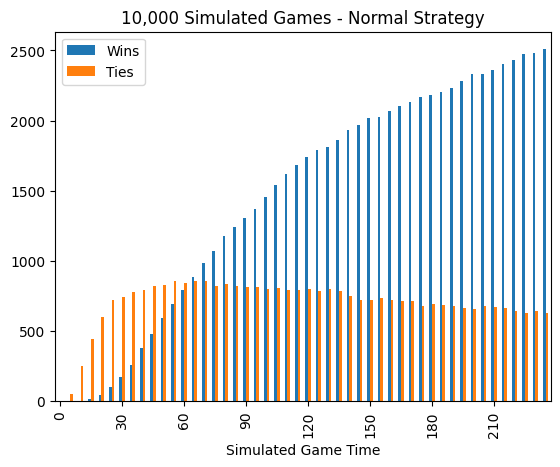

In [23]:
normal_strat.loc[:,('Wins','Ties')].plot.bar()
plt.xticks(np.arange(0, len(game_time),6))
plt.yticks(np.arange(0,2600,500))
plt.legend(loc = 2)
plt.title('10,000 Simulated Games - Normal Strategy')

In [24]:
wins_vec = pd.Series(len(game_time))
ties_vec = pd.Series(len(game_time))
fouls_vec = pd.Series(len(game_time))
fouls_opp_vec = pd.Series(len(game_time))

for time in game_time:
    wins = 0
    ties = 0

    raps_total_fouls = 0
    bucks_total_fouls = 0

    for i in seeds:
        raps = Team("Raps", score = 90, freethrow_percentage=0.804,twopoint_percentage=0.539,threepoint_percentage=0.366,tov_percentage=0.15)
        bucks = Team("Bucks", score = 93, freethrow_percentage=0.773,twopoint_percentage=0.565,threepoint_percentage=0.353,tov_percentage=0.15)

        raps_score, bucks_score, raps_fouls, bucks_fouls = simulate_game_2(raps, bucks, game_clock = time, seed = i)

        raps_total_fouls += raps_fouls
        bucks_total_fouls += bucks_fouls

        if raps_score > bucks_score:
            wins += 1

        if raps_score == bucks_score:
            ties += 1

    raps_avg_fouls = raps_total_fouls / iterations
    bucks_avg_fouls = bucks_total_fouls / iterations
    
    wins_vec[time] = wins
    ties_vec[time] = ties
    fouls_vec[time] = raps_avg_fouls
    fouls_opp_vec[time] = bucks_avg_fouls

hack_strat = pd.DataFrame({"Simulated Game Time" : game_time, "Wins" : wins_vec, "Ties" : ties_vec, "Avg Fouls" : fouls_vec}).set_index('Simulated Game Time')
# hack_strat

Text(0.5, 1.0, '10,000 Simulated Games - Hack Strategy')

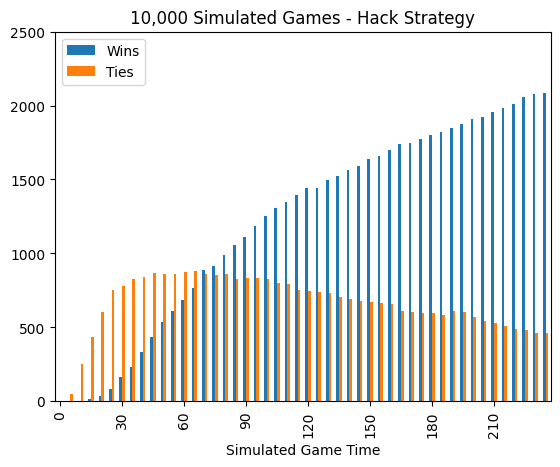

In [25]:
hack_strat.loc[:,('Wins','Ties')].plot.bar()
plt.xticks(np.arange(0, len(game_time),6))
plt.yticks(np.arange(0,2600,500))
plt.legend(loc = 2)
plt.title('10,000 Simulated Games - Hack Strategy')

([<matplotlib.axis.XTick at 0x1ebb66af150>,
 [Text(0, 0, '0'),
  Text(6, 0, '30'),
  Text(12, 0, '60'),
  Text(18, 0, '90'),
  Text(24, 0, '120'),
  Text(30, 0, '150'),
  Text(36, 0, '180'),
  Text(42, 0, '210')])

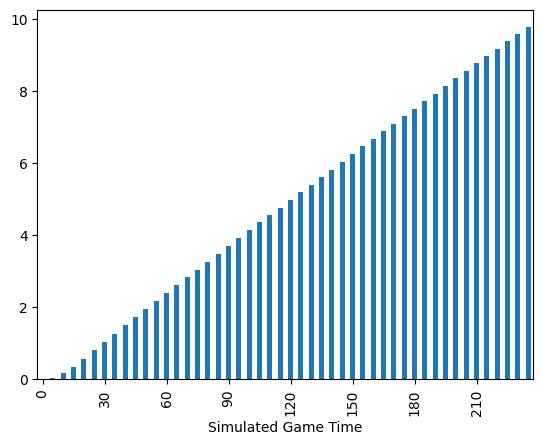

In [26]:
hack_strat.loc[:,('Avg Fouls')].plot.bar()
plt.xticks(np.arange(0, len(game_time),6))

Text(0.5, 1.0, 'Added Wins & Ties - Hack Strategy')

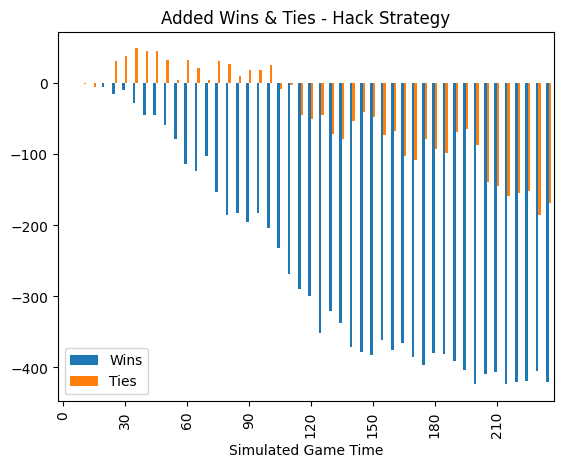

In [27]:
hack_strat.loc[:,('Wins','Ties')].subtract(normal_strat.loc[:,('Wins','Ties')]).plot.bar()
plt.xticks(np.arange(0, len(game_time),6))
plt.title('Added Wins & Ties - Hack Strategy')

We don't see a definitive benefit of intentionally fouling. It leads to more ties but this number is offset by the amount of wins lost when intentionally fouling.

Foul immediately or worst shooter?

In [28]:
extra_time = np.arange(0,9) # extra seconds for the ball to find Giannis
wins_vec = pd.Series(len(extra_time))
ties_vec = pd.Series(len(extra_time))
fouls_vec = pd.Series(len(extra_time))
fouls_opp_vec = pd.Series(len(extra_time))


for time in extra_time:
    wins = 0
    ties = 0

    raps_total_fouls = 0
    bucks_total_fouls = 0

    for i in seeds:
        raps = Team("Raps", score = 90, freethrow_percentage=0.804,twopoint_percentage=0.539,threepoint_percentage=0.366,tov_percentage=0.15)
        bucks = Team("Bucks", score = 93, freethrow_percentage=0.729,twopoint_percentage=0.565,threepoint_percentage=0.353,tov_percentage=0.15) # ft change to just Gianiss'
        # bucks = Team("Bucks", score = 93, freethrow_percentage=0.773,twopoint_percentage=0.565,threepoint_percentage=0.353,tov_percentage=0.15)

        raps_score, bucks_score, raps_fouls, bucks_fouls = simulate_game_2(raps, bucks, extra_seconds_foul = time, seed = i)
        # raps_score, bucks_score, raps_fouls, bucks_fouls = simulate_game_2(raps, bucks, extra_seconds_foul = 0, seed = i)

        raps_total_fouls += raps_fouls
        bucks_total_fouls += bucks_fouls
 
        if raps_score > bucks_score:
            wins += 1

        if raps_score == bucks_score:
            ties += 1

    raps_avg_fouls = raps_total_fouls / iterations
    bucks_avg_fouls = bucks_total_fouls / iterations

    wins_vec[time] = wins
    ties_vec[time] = ties
    fouls_vec[time] = raps_avg_fouls
    fouls_opp_vec[time] = bucks_avg_fouls

giannis = pd.DataFrame({"Extra Seconds to foul" : extra_time, "Wins" : wins_vec, "Ties" : ties_vec, "Avg Fouls" : fouls_vec}).set_index('Extra Seconds to foul')
# giannis

C:\Users\j_chr\AppData\Local\Temp\ipykernel_11136\2425777624.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.9961' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fouls_vec[time] = raps_avg_fouls
C:\Users\j_chr\AppData\Local\Temp\ipykernel_11136\2425777624.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9176' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fouls_opp_vec[time] = bucks_avg_fouls


Text(0.5, 1.0, '10,000 Simulated Games - Foul Giannis')

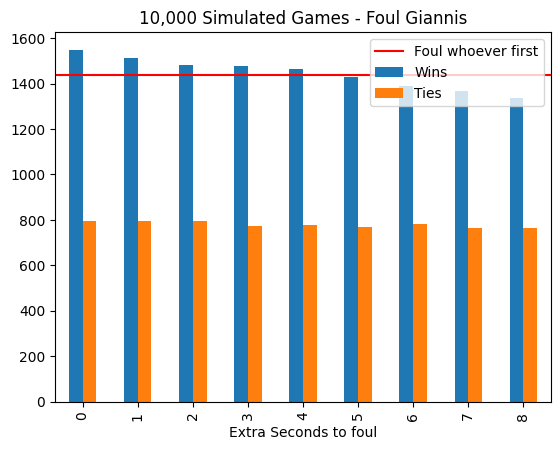

In [29]:
giannis.loc[:,('Wins','Ties')].plot.bar()
plt.xticks(np.arange(0, len(extra_time)))
plt.axhline(y = 1439, color = 'r', linestyle = '-', label = "Foul whoever first")
plt.legend()
plt.title('10,000 Simulated Games - Foul Giannis')

If the ball is not in Giannis' hands after four extra seconds, foul who ever

Let's see if different teams have different results:

In [30]:
game_time = np.arange(0,2*60,5)

In [31]:
wins_vec = pd.Series(len(game_time))
ties_vec = pd.Series(len(game_time))
fouls_vec = pd.Series(len(game_time))
fouls_opp_vec = pd.Series(len(game_time))

for time in game_time:
    wins = 0
    ties = 0

    purdue_total_fouls = 0
    uconn_total_fouls = 0

    for i in seeds:
        # The shot % below for each team is from the official NCAA website
        purdue = Team("Purdue", score = 90, freethrow_percentage=0.721,twopoint_percentage=0.4031,threepoint_percentage=0.408,tov_percentage=0.15)
        uconn = Team("Uconn", score = 93, freethrow_percentage=0.742,twopoint_percentage=0.5852,threepoint_percentage=0.367,tov_percentage=0.15)

        purdue_score, uconn_score, purdue_fouls, uconn_fouls = simulate_game_2(purdue, uconn, game_clock = time, hack_strat = False, seed = i)

        purdue_total_fouls += purdue_fouls
        uconn_total_fouls += uconn_fouls

        if purdue_score > uconn_score:
            wins += 1

        if purdue_score == uconn_score:
            ties += 1

    purdue_avg_fouls = purdue_total_fouls / iterations
    uconn_avg_fouls = uconn_total_fouls / iterations

    wins_vec[time] = wins
    ties_vec[time] = ties
    fouls_vec[time] = purdue_avg_fouls
    fouls_opp_vec[time] = uconn_avg_fouls

purdue_normal = pd.DataFrame({"Simulated Game Time" : game_time, "Wins" : wins_vec, "Ties" : ties_vec, "Avg Fouls" : fouls_vec}).set_index('Simulated Game Time')

In [32]:
wins_vec = pd.Series(len(game_time))
ties_vec = pd.Series(len(game_time))
fouls_vec = pd.Series(len(game_time))
fouls_opp_vec = pd.Series(len(game_time))

for time in game_time:
    wins = 0
    ties = 0

    purdue_total_fouls = 0
    uconn_total_fouls = 0

    for i in seeds:
        purdue = Team("Purdue", score = 90, freethrow_percentage=0.721,twopoint_percentage=0.4031,threepoint_percentage=0.408,tov_percentage=0.15)
        uconn = Team("Uconn", score = 93, freethrow_percentage=0.742,twopoint_percentage=0.5852,threepoint_percentage=0.367,tov_percentage=0.15)

        purdue_score, uconn_score, purdue_fouls, uconn_fouls = simulate_game_2(purdue, uconn, game_clock = time, seed = i)

        purdue_total_fouls += purdue_fouls
        uconn_total_fouls += uconn_fouls

        if purdue_score > uconn_score:
            wins += 1

        if purdue_score == uconn_score:
            ties += 1

    purdue_avg_fouls = purdue_total_fouls / iterations
    uconn_avg_fouls = uconn_total_fouls / iterations

    wins_vec[time] = wins
    ties_vec[time] = ties
    fouls_vec[time] = purdue_avg_fouls
    fouls_opp_vec[time] = uconn_avg_fouls

purdue_hack = pd.DataFrame({"Simulated Game Time" : game_time, "Wins" : wins_vec, "Ties" : ties_vec, "Avg Fouls" : fouls_vec}).set_index('Simulated Game Time')


Text(0.5, 1.0, 'Added Wins & Ties - Hack Strategy - Purdue v Uconn')

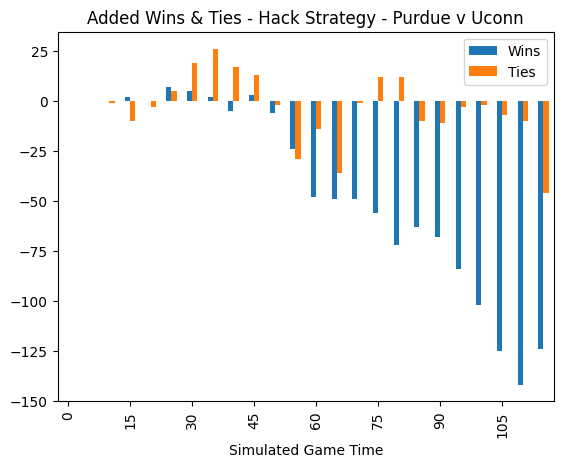

In [33]:
purdue_hack.loc[:,('Wins','Ties')].subtract(purdue_normal.loc[:,('Wins','Ties')]).plot.bar()
plt.xticks(np.arange(0, len(game_time),3))
plt.title('Added Wins & Ties - Hack Strategy - Purdue v Uconn')